In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [41]:
eurUsd = pd.read_csv('EURUSD60.csv',sep='\t')
eurUsd['Volume'] = eurUsd['Volume'].shift(1)
eurUsd.fillna(0,inplace=True)
eurUsd

,Date,Open,High,Low,Close,Volume
0,2013-09-16 16:00,1.33488,1.33552,1.33365,1.33387,0.0
1,2013-09-16 17:00,1.33390,1.33452,1.33367,1.33443,7916.0
2,2013-09-16 18:00,1.33446,1.33484,1.33309,1.33329,5713.0
3,2013-09-16 19:00,1.33331,1.33409,1.33301,1.33369,5338.0
4,2013-09-16 20:00,1.33369,1.33390,1.33330,1.33335,2848.0
...,...,...,...,...,...,...
49995,2021-09-24 20:00,1.17163,1.17222,1.17155,1.17181,901.0
49996,2021-09-26 21:00,1.17253,1.17261,1.17160,1.17208,1586.0
49997,2021-09-26 22:00,1.17208,1.17222,1.17170,1.17201,1486.0
49998,2021-09-26 23:00,1.17201,1.17238,1.17175,1.17224,1096.0


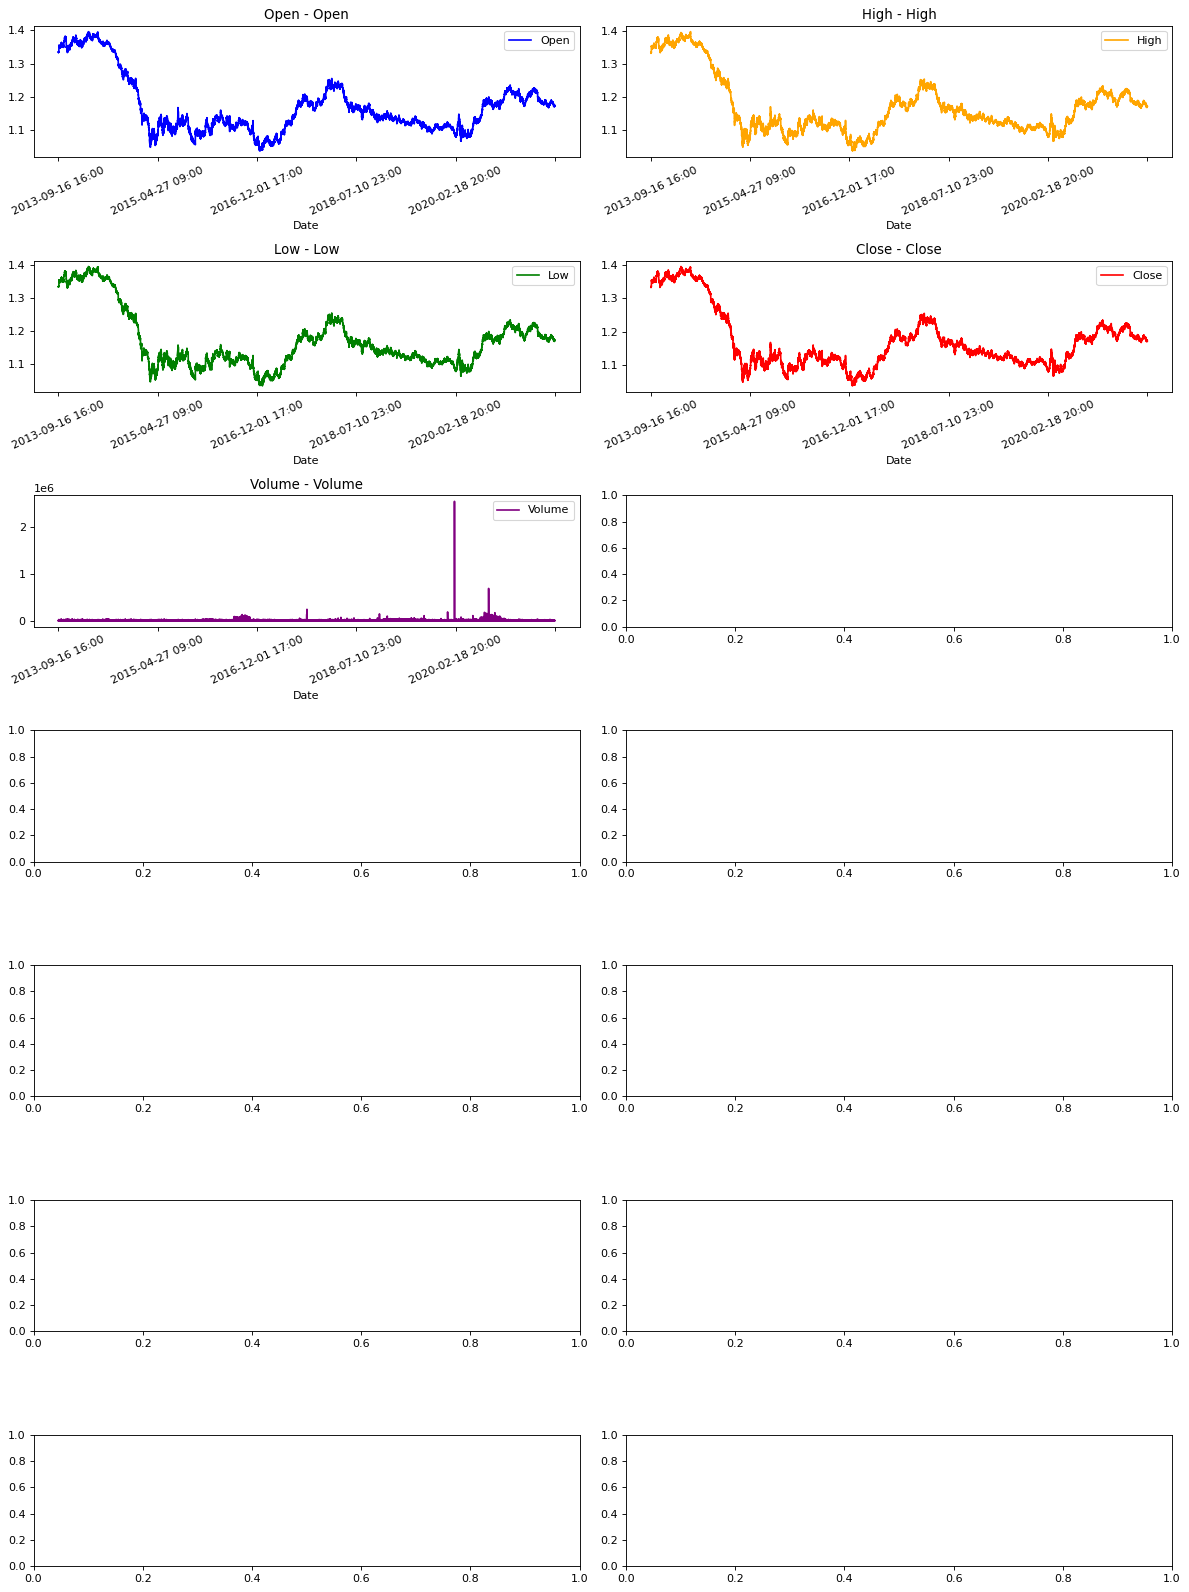

In [44]:
titles = ['Open','High','Low','Close','Volume']
feature_keys = ['Open','High','Low','Close','Volume']

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple"
]

date_time_key = "Date"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(eurUsd)

In [45]:
split_fraction = 0.715
train_split = int(split_fraction * int(eurUsd.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [48]:
selected_features = ['Open','High','Low','Close','Volume']
features = eurUsd[selected_features]
features.index = eurUsd[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [50]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(5)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [51]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [54]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(5)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 5)
Target shape: (256, 1)


In [55]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 5)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [56]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
137/137 [==============================] - 32s 177ms/step - loss: 0.0996 - val_loss: 0.0581

Epoch 00001: val_loss improved from inf to 0.05808, saving model to model_checkpoint.h5
Epoch 2/10
137/137 [==============================] - 27s 164ms/step - loss: 0.0432 - val_loss: 0.0303

Epoch 00002: val_loss improved from 0.05808 to 0.03030, saving model to model_checkpoint.h5
Epoch 3/10
137/137 [==============================] - 27s 161ms/step - loss: 0.0348 - val_loss: 0.0407

Epoch 00003: val_loss did not improve from 0.03030
Epoch 4/10
137/137 [==============================] - 26s 155ms/step - loss: 0.0318 - val_loss: 0.0238

Epoch 00004: val_loss improved from 0.03030 to 0.02376, saving model to model_checkpoint.h5
Epoch 5/10
137/137 [==============================] - 26s 155ms/step - loss: 0.0279 - val_loss: 0.0294

Epoch 00005: val_loss did not improve from 0.02376
Epoch 6/10
137/137 [==============================] - 27s 162ms/step - loss: 0.0259 - val_loss: 0.0194

Ep

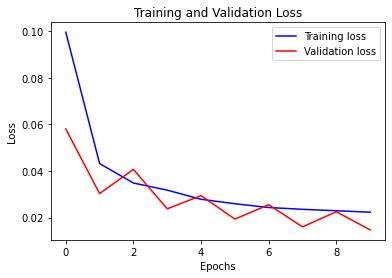

In [57]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

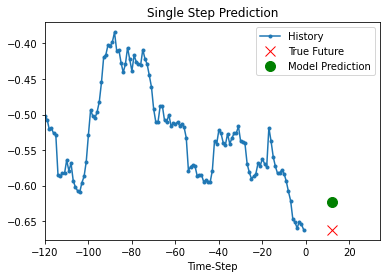

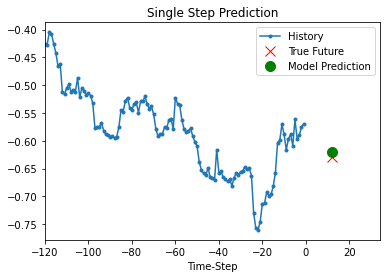

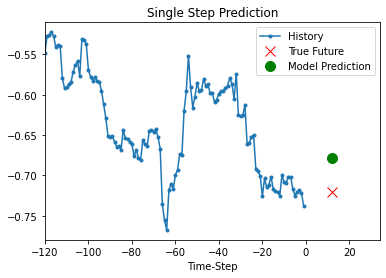

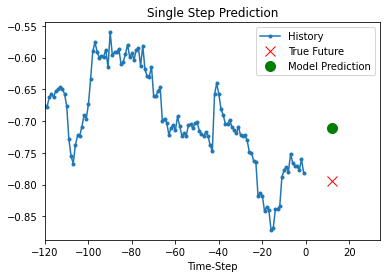

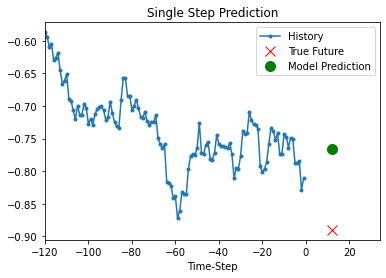

In [58]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )